In [2]:
%matplotlib inline
%pylab inline

import pandas as pd
import matplotlib.pyplot as plt
import plotly
import numpy as np
import seaborn as sns
import calendar
import pandasql as pdsql
from scipy.stats import linregress
from scipy.interpolate import spline
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import  bootstrap_plot

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import pickle
import requests
import io

pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


/Users/remi/anaconda/envs/remi_insight/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.




## Class data integration

In [3]:
def load_911db_realtime():    
    url="https://storage.googleapis.com/montco-stats/tz.csv"
    d=requests.get(url).content
    d=pd.read_csv(io.StringIO(d.decode('utf-8')), header=0,names=['lat', 'lng','desc','zip','title','timeStamp','twp','e'],dtype={'lat':float,'lng':float,'desc':str,'zip':str,'title':str,'timeStamp':str,'twp':str,'e':int})   
    d=pd.DataFrame(d)
    return d

def save_911db(df, dir, name):
    df.to_csv(dir + name)


def load_911db_local():
    d = [];
    d=pd.read_csv('../data/911db_all_20170621_21_53.csv', header=0,names=['lat', 'lng','desc','zip','title','timeStamp','twp','e'],dtype={'lat':float,'lng':float,'desc':str,'zip':str,'title':str,'timeStamp':str,'twp':str,'e':int})    
    d=pd.DataFrame(d)
    return d

# type_db = 1 'EMS'
# type_db = 2 'Fire'
# type_db = 3 'Traffic'
# type_db = any number 'all'
def get_db_type(DB, type_db):
    
    
    if type_db == 1:
        sql1 = "select * from DB where title like 'EMS:%'"
        d3 = pdsql.sqldf(sql1, {'DB':DB})
        return pd.DataFrame(d3)
    
    if type_db == 2:
        sql1 = "select * from DB where title like 'Fire:%'"
        d3 = pdsql.sqldf(sql1, {'DB':DB})
        return pd.DataFrame(d3)
    
    if type_db == 3:
        sql1 = "select * from DB where title like 'Traffic:%'"
        d3 = pdsql.sqldf(sql1, {'DB':DB})
        return pd.DataFrame(d3)
    
    return DB

def add_data_time_columns(dt): 
    
    # ADD THE DATE AND TIME IN SINGLE COLUMNS FOR GROUPPING THE CALLS BY HOURS
    dt1 = np.zeros((dt.shape[0], 4))

    for i in range(0,dt.shape[0]):
        s = dt.timeStamp[i]
        s = s.split(' ')
        ymd = s[0]. split('-')
        hms = s[1]. split(':')
        dt1[i,0]=int(ymd[0])
        dt1[i,1]=int(ymd[1])
        dt1[i,2]=int(ymd[2])
        dt1[i,3]=int(hms[0])

    dt1 = pd.DataFrame(dt1)
    dt2 = pd.concat([dt,dt1], axis=1)

    names = dt2.columns.tolist()
    names[names.index(0)] = 'year'
    names[names.index(1)] = 'month'
    names[names.index(2)] = 'day'
    names[names.index(3)] = 'hour'
    dt2.columns = names
    dt2 = pd.DataFrame(dt2)
    
    # RE-INDEX WITH THE TIME STAMP
    #pysql_loc = lambda q: pdsql.sqldf(q, locals())
    #dt3 = pysql_loc("select timeStamp, year, month, day, hour, count(*) as calls from TAB1 where title like 'EMS:%' group by year, month, day, hour")
    sql1 = "select timeStamp, year, month, day, hour, count(*) as calls from dt2 where title like 'EMS:%' group by year, month, day, hour"
    dt3 = pdsql.sqldf(sql1, {'dt2':dt2})
    dt3 = pd.DataFrame(dt3)
    dt4 = dt3.set_index('timeStamp')
    del dt4.index.name
    
    return dt4

def make_timeserie_hourcalls(df):
    
    # group the calls by hours
    sql1 = "select year, month, day, hour, calls from df group by  year, month, day, hour"
    df2 = pdsql.sqldf(sql1, {'df':df})
    df2 = pd.DataFrame(df2)

    
    # time stamp
    df2.index = pd.to_datetime(df2.loc[:, ['year', 'month', 'day', 'hour']])

    del df2['year']
    del df2['month']
    del df2['day']
    del df2['hour']
    
    return df2

def make_timeserie_daycalls(df):
    
    # group the calls by hours
    sql1 = "select year, month, day, sum(calls) as calls from df group by  year, month, day"
    df2 = pdsql.sqldf(sql1, {'df':df})
    df2 = pd.DataFrame(df2)

    
    # time stamp
    df2.index = pd.to_datetime(df2.loc[:, ['year', 'month', 'day']])

    del df2['year']
    del df2['month']
    del df2['day']
    #del df2['hour']
    
    return df2

## Class forecast

In [4]:
def build_X_Y(df, DEGREE, REPEATS, SHIFT,WIN_HOURS, WIN_HOURS_TRAIN):
    """
    build the dataset with periodic temporal informatino as features
    the features are listed below. each training observation is built by shifting the measurements +1 hour 
    to the future until the end of the time series
    
     columns:
     
        STD(mean_1_num_call, ..., mean_4_num_call)       see mean_i_num_call below
        MEAN(mean_1_num_call, ..., mean_4_num_call)
        SLOPE(mean_1_num_call, ..., mean_4_num_call)
        Year                                             referes to future prediction
        Month                                            referes to future prediction
        Day                                              referes to future prediction
        Hour                                             referes to future prediction
        mean_1_num_call(T-1,    T-2,    T-3,    T-4)        
        mean_2_num_call(T-1-24, T-2-24, T-3-24, T-4-24)  SHIFT=24 back to past + WIN_HOURS_TRAIN=4 time window
        mean_3_num_call(T-1-48, T-2-48, T-3-48, T-4-48)
        mean_4_num_call(T-1-72, T-2-72, T-3-72, T-4-72)

        mean_num_call(T+1,    T+2,    T+3,    T+4)       this is Y
        
        poly_features(DEGREE)                            combination of all above features with degree DEGREE
        
        
    Parameters
    ----------
    df                                               original time series with time columns for y,m,d,h
    SHIFT = 24                                       periods of single mearuement
    REPEATS = 4                                      number i  measurement (mean_i_num_call) back in the past
    WIN_HOURS_TRAIN=2                                time window of measurement in the past   (Y)
    WIN_HOURS=4                                      time window of measurement to the future (X)
    DEGREE                                           deegre of poly for combination of features


    Returns
    -------
    dataset of features values X plus the Y [n_features,m_observations] and [1,m_observations]
        
         
    """
  
    LEN_TOT_X = (WIN_HOURS_TRAIN-(WIN_HOURS-SHIFT))*(REPEATS-1)+WIN_HOURS

    nn = df.calls.shape[0]
    nn2 = nn-2*SHIFT*REPEATS

    TS1 = np.zeros((nn2, REPEATS+1)) # +1 is the y
    TS1_PLUS = np.zeros((nn2, 4))

    for i in range(0,nn2): # number of traing and test examples to use
        for j in range(0,REPEATS):
            p = i+j*SHIFT
            #DEBUG -----------------------------------------------------------
            #print(str("x:") +  str(p) + str("-") + str(p+LEN_X_te-1))
            #-----------------------------------------------------------------
            #TS1[i,j] = int(np.mean(DT1.calls[p:p+LEN_X_te]))
            TS1[i,j] = np.mean(df.calls[p:p+WIN_HOURS]) 
            
        TS1_PLUS[i,0] = int(df.year[p+2])
        TS1_PLUS[i,1] = int(df.month[p+2])
        TS1_PLUS[i,2] = int(df.day[p+2])
        #TS1_PLUS[i,3] = int(df.hour[p+2])

        p = i+(REPEATS-1)*SHIFT+WIN_HOURS
        TS1_PLUS[i,3] = int(df.hour[p+2]) # hour of Y
        #TS1[i,NUM_te] = int(np.mean(DT1.calls[p:p+LEN_Y_te])) # next 8 hours (around the period)
        TS1[i,REPEATS] = np.mean(df.calls[p:p+WIN_HOURS_TRAIN]) # next 8 hours (around the period)
        #DEBUG----------------------------------------------------------------
        #print(str("y:") +  str(p) + str("-") + str(p+LEN_Y_te-1))
        #-----------------------------------------------------------------
    
    # -------------------   
    # ADDITIONAL FEATURES
    # -------------------
    # Standard deviation
    a1 = np.std(TS1[:,0:TS1.shape[1]-1],axis=1)

    # Mean 
    a2 = np.mean(TS1[:,0:TS1.shape[1]-1],axis=1)

    # slope
    a3 = np.abs(TS1[:,0]-TS1[:,TS1.shape[1]-1])/LEN_TOT_X

    # concatenate all
    A = np.column_stack((a1, a2, a3)) # a3,  a4))
    TS2 = np.concatenate((A,TS1_PLUS, TS1), axis=1)

    #plot(x,y, '.')
    TS3 = pd.DataFrame(TS2)
    
    # -----------------
    # POLYNOMIALIZATION
    # -----------------
    X = np.array(TS3)[:,0:TS3.shape[1]-1]
    Y = np.array(TS3)[:,TS3.shape[1]-1]
    p = PolynomialFeatures(DEGREE,  include_bias=True)
    X2 = p.fit_transform(X)
    Y2 = Y

    a = pd.DataFrame(X2)
    a

    return X2,Y2


def model_train(X,Y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    
    X_train2 = scaler.fit(X_train).transform(X_train)
    
    model = linear_model.LinearRegression()
    
    model.fit(X_train2, y_train)
    
    return model, scaler, X_train, y_train, X_test, y_test


def model_test(model, scaler, X, Y):
    # rescale test 
    Xsca = scaler.transform(X)
    Ypred = model.predict(Xsca)
    score = model.score(Xsca,Y)
    return Ypred, score


def model_save(model, scaler, model_filename, scaler_filename):
    pickle.dump(model, open('../model/911_model.sav', 'wb'))
    pickle.dump(scaler, open('../model/911_scaler.sav', 'wb'))
    return model_filename, scaler_filename



In [41]:
pd.DataFrame(X[:,1:15]).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.836193,10.4375,0.107143,2015.0,12.0,13.0,21.0,11.00,9.75,11.5,9.50,0.699219,8.727765,0.089592
1,1.403122,8.7500,0.025000,2015.0,12.0,13.0,22.0,8.75,7.25,11.0,8.00,1.968750,12.277313,0.035078
2,2.010713,7.1875,0.021429,2015.0,12.0,13.0,23.0,8.50,4.25,9.5,6.50,4.042969,14.452003,0.043087
3,2.267295,7.1250,0.032143,2015.0,12.0,14.0,0.0,5.75,4.50,10.5,7.75,5.140625,16.154474,0.072877
4,1.451023,5.5625,0.010714,2015.0,12.0,14.0,1.0,4.25,4.75,8.0,5.25,2.105469,8.071317,0.015547


In [4]:
Y

NameError: name 'Y' is not defined

In [5]:
# ---------
# data load
# ---------
df_all = load_911db_realtime()
df_ems = get_db_type(df_all, 1)
df_ems_timefeatures = add_data_time_columns(df_ems)

In [6]:
# ---------
# data prep
# ---------
DEGREE = 3
SHIFT = 24
WIN_HOURS = 4
WIN_HOURS_TRAIN = 2
REPEATS = 10

X,Y = build_X_Y(df_ems_timefeatures, DEGREE, REPEATS, SHIFT,WIN_HOURS, WIN_HOURS_TRAIN)


In [7]:
# -----------
# model train
# -----------
mod , sca , xtr,ytr, xte, yte = model_train(X,Y, 0.4)

# -----------
# model test
# -----------
Ypred, score = model_test(mod,sca,xte,yte)

# -----------
# model save
# -----------
model_save(mod,sca, '../model/911_model.sav', '../model/911_scaler.sav')

('../model/911_model.sav', '../model/911_scaler.sav')

### show prediction

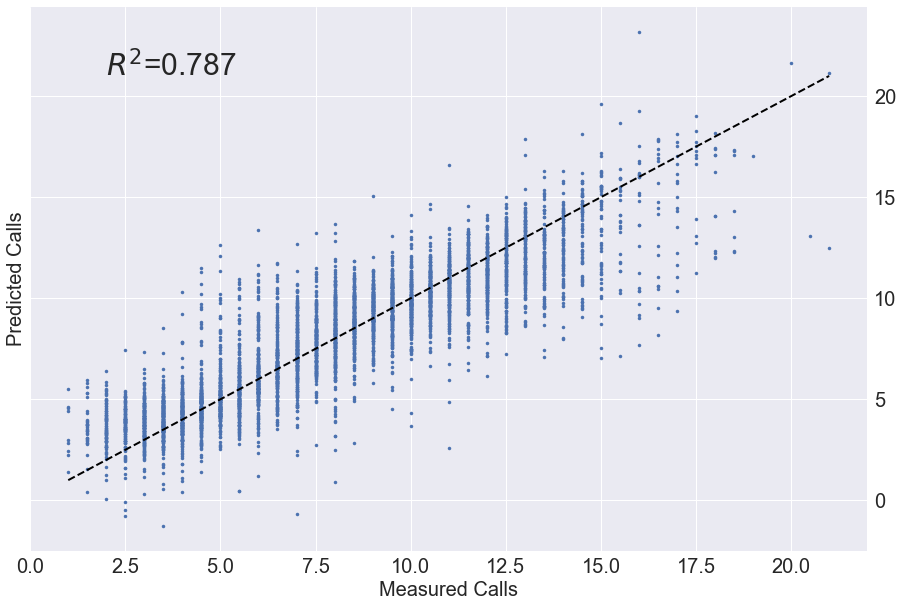

In [8]:
# plot model prediction
plt.plot(yte,Ypred, '.')
plt.plot([yte.min(), yte.max()], [yte.min(), yte.max()], 'k--', lw=2)

plt.xlabel('Measured Calls', fontsize=20)
plt.ylabel('Predicted Calls', fontsize=20)
plt.text(2, yte.max(), "$R^2$=" + str(np.round(score,3)), fontsize=30)
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on', labelsize=20)
plt.tick_params(axis='x',  labelsize=20)

## Normality of the residuals

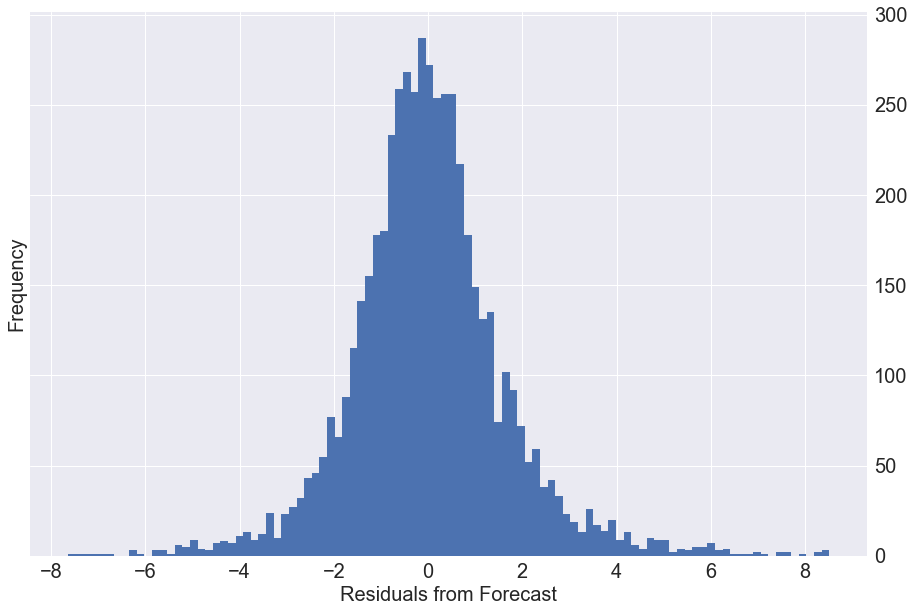

In [15]:
residuals = yte-Ypred

plt.hist(residuals, 100)

plt.xlabel('Residuals from Forecast', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on', labelsize=20)
plt.tick_params(axis='x',  labelsize=20)





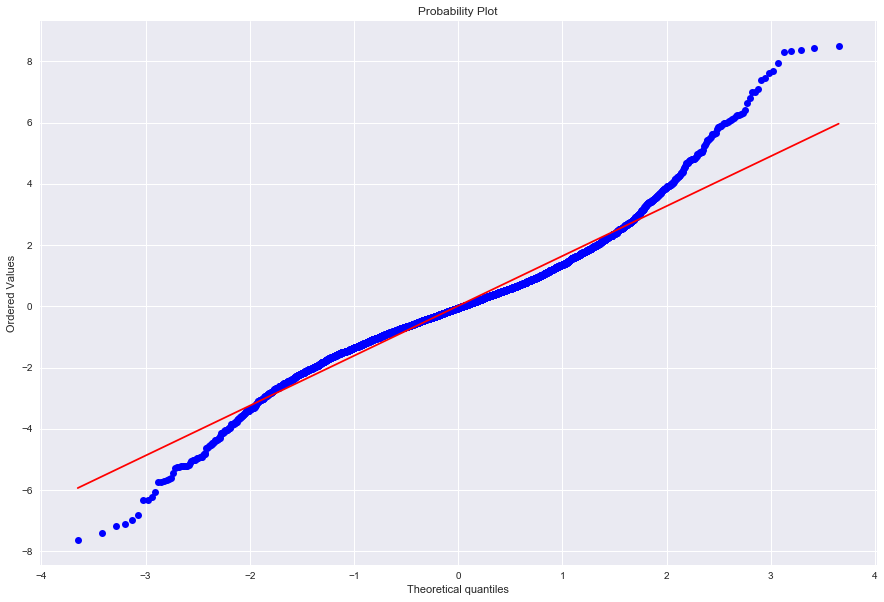

In [16]:
import numpy as np 
import pylab 
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()


## OLS model from statsmodel
this was used to validate the indipendence of the predictors. Indeed the Dublin-watson test give a value of 2 which means that the  predictors are indepented

In [51]:
import statsmodels.api as sm

model = sm.OLS(ytr,xtr)
results = model.fit()
plt.plot( yte, results.predict(xte) '.r')


SyntaxError: invalid syntax (<ipython-input-51-e4f0e9a0449f>, line 5)

In [50]:
model.score(xte,yte)

ValueError: shapes (1140,1140) and (5328,1140) not aligned: 1140 (dim 1) != 5328 (dim 0)

### summary

In [10]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     45.20
Date:                Thu, 13 Jul 2017   Prob (F-statistic):               0.00
Time:                        00:17:33   Log-Likelihood:                -14178.
No. Observations:                7991   AIC:                         3.001e+04
Df Residuals:                    7163   BIC:                         3.580e+04
Df Model:                         827                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3755      0.990      0.379      0.705      -1.566       2.317
x1             0.3174      0.684      0.464      0.643      -1.024       1.659
x2             1.6674      3.745      0.445      0.656      -5.674       9.008
x3             0.0252      0.014      1.825      0.068      -0.002       0.052
x4           338.2616    902.258      0.375      0.708   -1430.431    2106.954
x5             2.0129      5.374      0.375      0.708      -8.521      12.547
x6             4.0686     11.372      0.358      0.721     -18.223      26.360
x7             1.8308      5.447      0.336      0.737      -8.846      12.508
x8             1.7711      3.783      0.468      0.640      -5.645       9.187
x9             1.7023      3.706      0.459      0.646      -5.563       8.967
x10            1.6890      3.780      0.447      0.655      -5.721       9.099
x11            1.6720      3.682      0.454      0.650      -5.547       8.891
x12            1.6250      3.653      0.445      0.656      -5.535       8.785
x13            1.5581      3.657      0.426      0.670      -5.611       8.727
x14            1.7237      3.782      0.456      0.649      -5.691       9.138
x15            1.5863      3.801      0.417      0.676      -5.865       9.038
x16            1.6852      3.776      0.446      0.655      -5.718       9.088
x17            1.6648      3.806      0.437      0.662      -5.796       9.126
x18          -65.6410     31.869     -2.060      0.039    -128.113      -3.168
x19           18.2336     11.630      1.568      0.117      -4.564      41.032
x20          -49.0564     27.331     -1.795      0.073    -102.633       4.520
x21            0.4808      0.568      0.847      0.397      -0.632       1.594
x22          201.2884     85.463      2.355      0.019      33.755     368.822
x23          -44.2947     27.105     -1.634      0.102     -97.428       8.839
x24          -54.3236     42.213     -1.287      0.198    -137.074      28.427
x25         -173.0625    107.211     -1.614      0.107    -383.227      37.102
x26           -7.0830    116.831     -0.061      0.952    -236.106     221.940
x27         -145.1792    122.829     -1.182      0.237    -385.960      95.602
x28          211.3402    120.223      1.758      0.079     -24.333     447.013
x29           12.9639    121.169      0.107      0.915    -224.564     250.491
x30          -28.1358    114.046     -0.247      0.805    -251.699     195.427
x31          -24.7451    119.348     -0.207      0.836    -258.703     209.213
x32          134.7075    123.851      1.088      0.277    -108.077     377.492
x33          203.6496    120.677      1.688      0.092     -32.913     440.213
x34           -2.1187    116.257     -0.018      0.985    -230.016     225.779
x35            4.4787      2.417      1.853      0.064      -0.260       9.218
x3

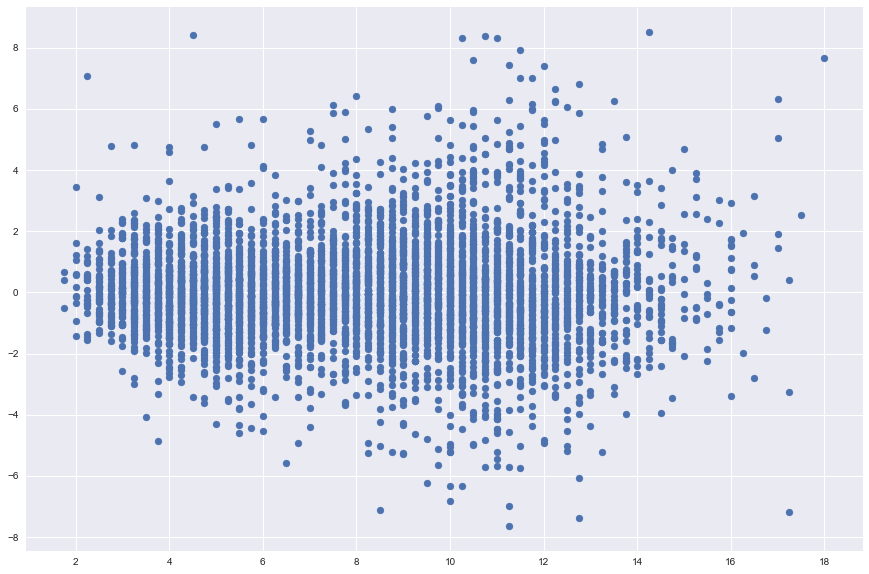

In [23]:
## dependence between the resuduals and the predictors should null

plt.scatter(xte[:,8],residuals)



In [46]:
# Eigen values: a single zero indicate colinearity

corr=pd.DataFrame(np.corrcoef(xte,rowvar=0))
corr[corr==0]

/Users/remi/anaconda/envs/remi_insight/lib/python3.5/site-packages/numpy/lib/function_base.py:3162: RuntimeWarning:

invalid value encountered in true_divide

/Users/remi/anaconda/envs/remi_insight/lib/python3.5/site-packages/numpy/lib/function_base.py:3163: RuntimeWarning:

invalid value encountered in true_divide



,0,1,2,3,4,5,6,7,8,9,...,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Gradient boosting

In [21]:
pd.DataFrame(xte[:,0:18])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.0,0.829533,6.825,0.007426,2016.0,11.0,23.0,2.0,7.50,6.00,6.00,6.00,8.25,6.50,6.75,6.50,8.25,6.50
1,1.0,1.682446,11.775,0.018564,2016.0,2.0,25.0,16.0,15.25,12.00,9.50,9.75,10.75,11.25,13.50,12.00,10.75,13.00
2,1.0,1.829617,9.200,0.011139,2017.0,3.0,5.0,14.0,7.75,8.25,8.50,11.00,9.25,7.75,9.75,6.50,10.00,13.25
3,1.0,1.475847,8.625,0.008663,2016.0,5.0,7.0,13.0,8.25,10.75,9.25,7.00,8.25,9.75,5.50,8.25,10.25,9.00
4,1.0,0.663796,4.375,0.009901,2016.0,12.0,28.0,8.0,4.00,3.50,3.75,5.00,4.25,3.75,5.50,5.25,4.00,4.75
5,1.0,1.346523,4.325,0.021040,2016.0,1.0,12.0,9.0,5.25,3.00,3.25,3.75,2.00,4.50,7.00,5.50,4.50,4.50
6,1.0,2.172125,10.275,0.029703,2017.0,5.0,24.0,0.0,11.50,11.00,13.25,11.25,12.75,8.25,10.75,6.75,6.75,10.50
7,1.0,1.204419,10.175,0.014851,2016.0,12.0,12.0,18.0,12.50,9.25,11.75,10.75,10.25,10.25,9.25,9.25,8.25,10.25
8,1.0,2.034699,11.350,0.021040,2017.0,6.0,8.0,19.0,13.75,11.25,11.50,14.00,9.25,10.50,8.75,14.50,11.25,8.75
9,1.0,1.458595,7.400,0.028465,2016.0,1.0,9.0,2.0,10.25,5.75,9.00,7.25,8.75,5.50,6.25,6.50,7.75,7.00


In [29]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import classification_report
import itertools


params = {'n_estimators': 500, 'max_depth': 6, 'min_samples_split': 2,
         'learning_rate': 0.005}
model_gb = GradientBoostingRegressor(**params)
model_gb.fit(xtr[:,0:18],ytr)
Y_pred = model_gb.predict(xte[:,0:18])


In [37]:
score = model_gb.score(xte[:,0:18], yte)

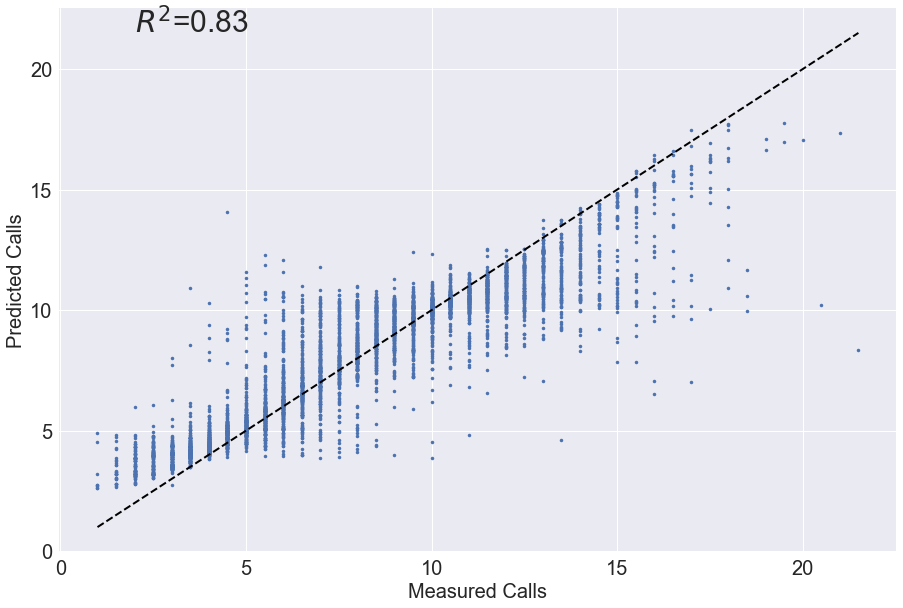

In [39]:
# plot model prediction
plt.plot(yte,Y_pred, '.')
plt.plot([yte.min(), yte.max()], [yte.min(), yte.max()], 'k--', lw=2)

plt.xlabel('Measured Calls', fontsize=20)
plt.ylabel('Predicted Calls', fontsize=20)
plt.text(2, yte.max(), "$R^2$=" + str(np.round(score,3)), fontsize=30)
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off', labelsize=20)
plt.tick_params(axis='x',  labelsize=20)

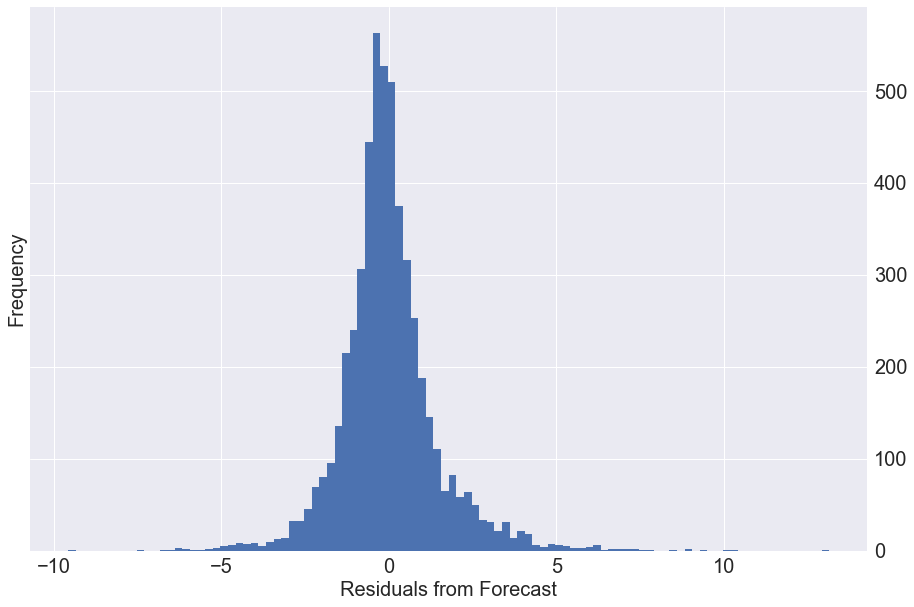

In [41]:
residuals = yte-Y_pred

plt.hist(residuals, 100)

plt.xlabel('Residuals from Forecast', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on', labelsize=20)
plt.tick_params(axis='x',  labelsize=20)


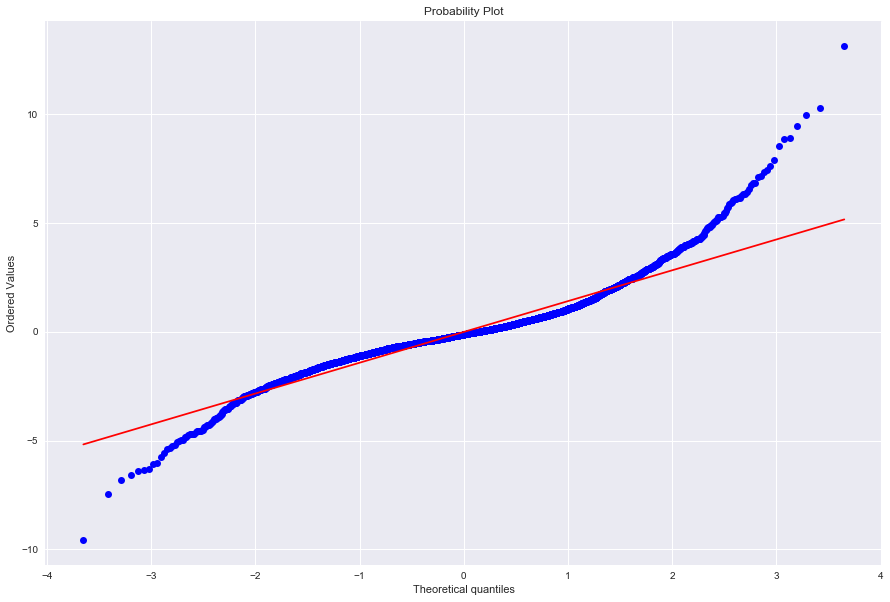

In [43]:
import numpy as np 
import pylab 
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

/Users/remi/anaconda/envs/remi_insight/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function staged_decision_function is deprecated;  and will be removed in 0.19



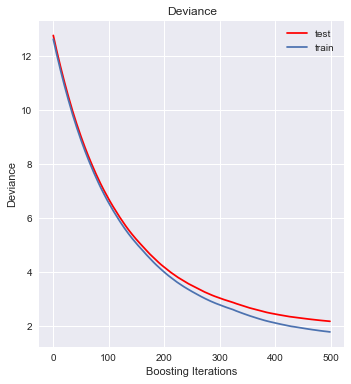

In [31]:
ne = len(model_gb.estimators_)
test_error = np.empty(ne)

for i,pred in enumerate(model_gb.staged_decision_function(xte[:,0:18])):
    test_error[i] = model_gb.loss_(np.array(yte), pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(ne), test_error, '-r', label='test')
plt.plot(np.arange(ne), model_gb.train_score_, label='train')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

/Users/remi/anaconda/envs/remi_insight/lib/python3.5/site-packages/matplotlib/cbook.py:2649: UserWarning:

Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'



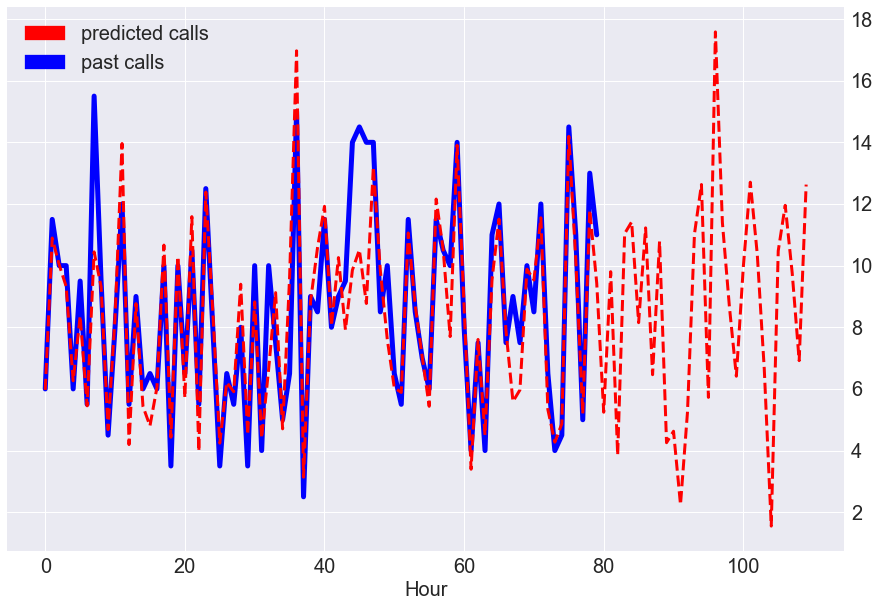

In [32]:
import matplotlib.patches as mpatches

plt.plot(yte[0:80], 'b', markersize=30, lw=6, linewidth=5)
plt.plot(Ypred[0:110], '--r', markersize=30, lw=6, linewidth=3)

red_patch = mpatches.Patch(color='red', label='predicted calls')
blue_patch = mpatches.Patch(color='blue', label='past calls')

#plt.xlabel('Time (hour)', fontsize=20)
plt.xlabel('Hour', fontsize=20)
#plt.ylabel('Calls', fontsize=20)
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on', labelsize=20)
plt.tick_params(axis='x',  labelsize=20)

plt.legend(handles=[red_patch, blue_patch], fontsize=20)
plt.show()
